In [1]:
#importing packages
%matplotlib inline
import matplotlib
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from Utility.IO import *


#### Load Dictionary

In [2]:
dic=load_dictionary()

In [3]:
cat_list0=dic.category.unique()
cat_list=np.delete(cat_list0,[0,8])
cat_list

array([u'school', u'admissions', u'academics', u'student', u'cost', u'aid',
       u'completion', u'earnings'], dtype=object)

#### Read data and transform

In [4]:
rpyrt0=get_rpyrt_by_class(1)

C:\Users\b_luo\AppData\Local\Continuum\anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2822: DtypeWarning: Columns (1,2,3,4,8,9,10,11,420,421,422,423,424,425,426,427,428,429,430,431,432,433,434,435,436,437,438,439,440,441,442,443,444,445,446,447,448,449,450,451,452,453,454,455,456,457,458,459,460,461,462,463,464,465,466,467,468,469,470,471,472,473,474,475,476,477,478,479,480,481,482,483,484,485,486,487,488,489,490,491,492,493,494,495,496,497,498,499,500,501,502,503,504,505,506,507,508,509,510,511,512,513,514,515,516,517,518,519,520,521,522,523,524,525,526,527,528,529,530,531,532,533,534,535,536,537,538,539,540,541,542,543,544,545,546,547,548,549,550,551,552,553,554,555,556,557,558,559,560,561,562,563,564,565,566,567,568,569,570,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610,611,612,613,614,615,616,617,618,619,620,621,622,623,624,625,626,627,628,629,630,631,632,6

In [5]:
rpyrt=rpyrt0

In [6]:
#rpyrt=rpyrt0.drop('OPEID6',axis=1)

In [7]:
y=np.log(rpyrt.RPY_1YR_RT/(1-rpyrt.RPY_1YR_RT))

In [8]:
rpyrt.head()

,RPY_1YR_RT,INSTNM,CITY,STABBR,ZIP,SCH_DEG,MAIN,NUMBRANCH,PREDDEG,HIGHDEG,...,C100_L4,D100_L4,TRANS_4,DTRANS_4,TRANS_L4,DTRANS_L4,ICLEVEL,UGDS_MEN,UGDS_WOMEN,Year
0,0.477044,Alabama A & M University,Normal,AL,35762.0,3.0,1,1,3,4,...,NaN,NaN,0.000000,1038.0,NaN,NaN,1.0,0.4709,0.5291,2007
1,0.608185,University of Alabama at Birmingham,Birmingham,AL,NaN,3.0,1,1,3,4,...,NaN,NaN,0.234477,1224.0,NaN,NaN,1.0,0.3956,0.6044,2007
2,0.657534,Amridge University,Montgomery,AL,NaN,3.0,1,1,3,4,...,NaN,NaN,0.600000,5.0,NaN,NaN,1.0,0.4752,0.5248,2007
3,0.657205,University of Alabama in Huntsville,Huntsville,AL,35899.0,3.0,1,1,3,4,...,NaN,NaN,0.331081,592.0,NaN,NaN,1.0,0.5169,0.4831,2007
4,0.432048,Alabama State University,Montgomery,AL,NaN,3.0,1,1,3,4,...,NaN,NaN,0.000000,1263.0,NaN,NaN,1.0,0.4026,0.5974,2007


#### Variable Screening

In [9]:
screen=prescreening_by_class(rpyrt,y=1,nobs=501)

In [10]:
rpyrt.fillna(0,inplace=True)

In [11]:
dic=dic.loc[dic['name'].isin(screen),:]

In [12]:
X=rpyrt[dic.name]
X=X/X.std()

In [13]:
X.shape

(35027, 500)

In [14]:
dic.groupby(['category']).count()

,desc,name
category,,
academics,33,33
admissions,20,20
aid,15,15
completion,317,317
cost,20,20
earnings,46,46
school,9,9
student,40,40


### PCA

school
(35027, 9)
admissions
(35027, 20)
academics
(35027, 33)
student
(35027, 40)
cost
(35027, 20)
aid
(35027, 15)
completion
(35027, 317)
earnings
(35027, 46)


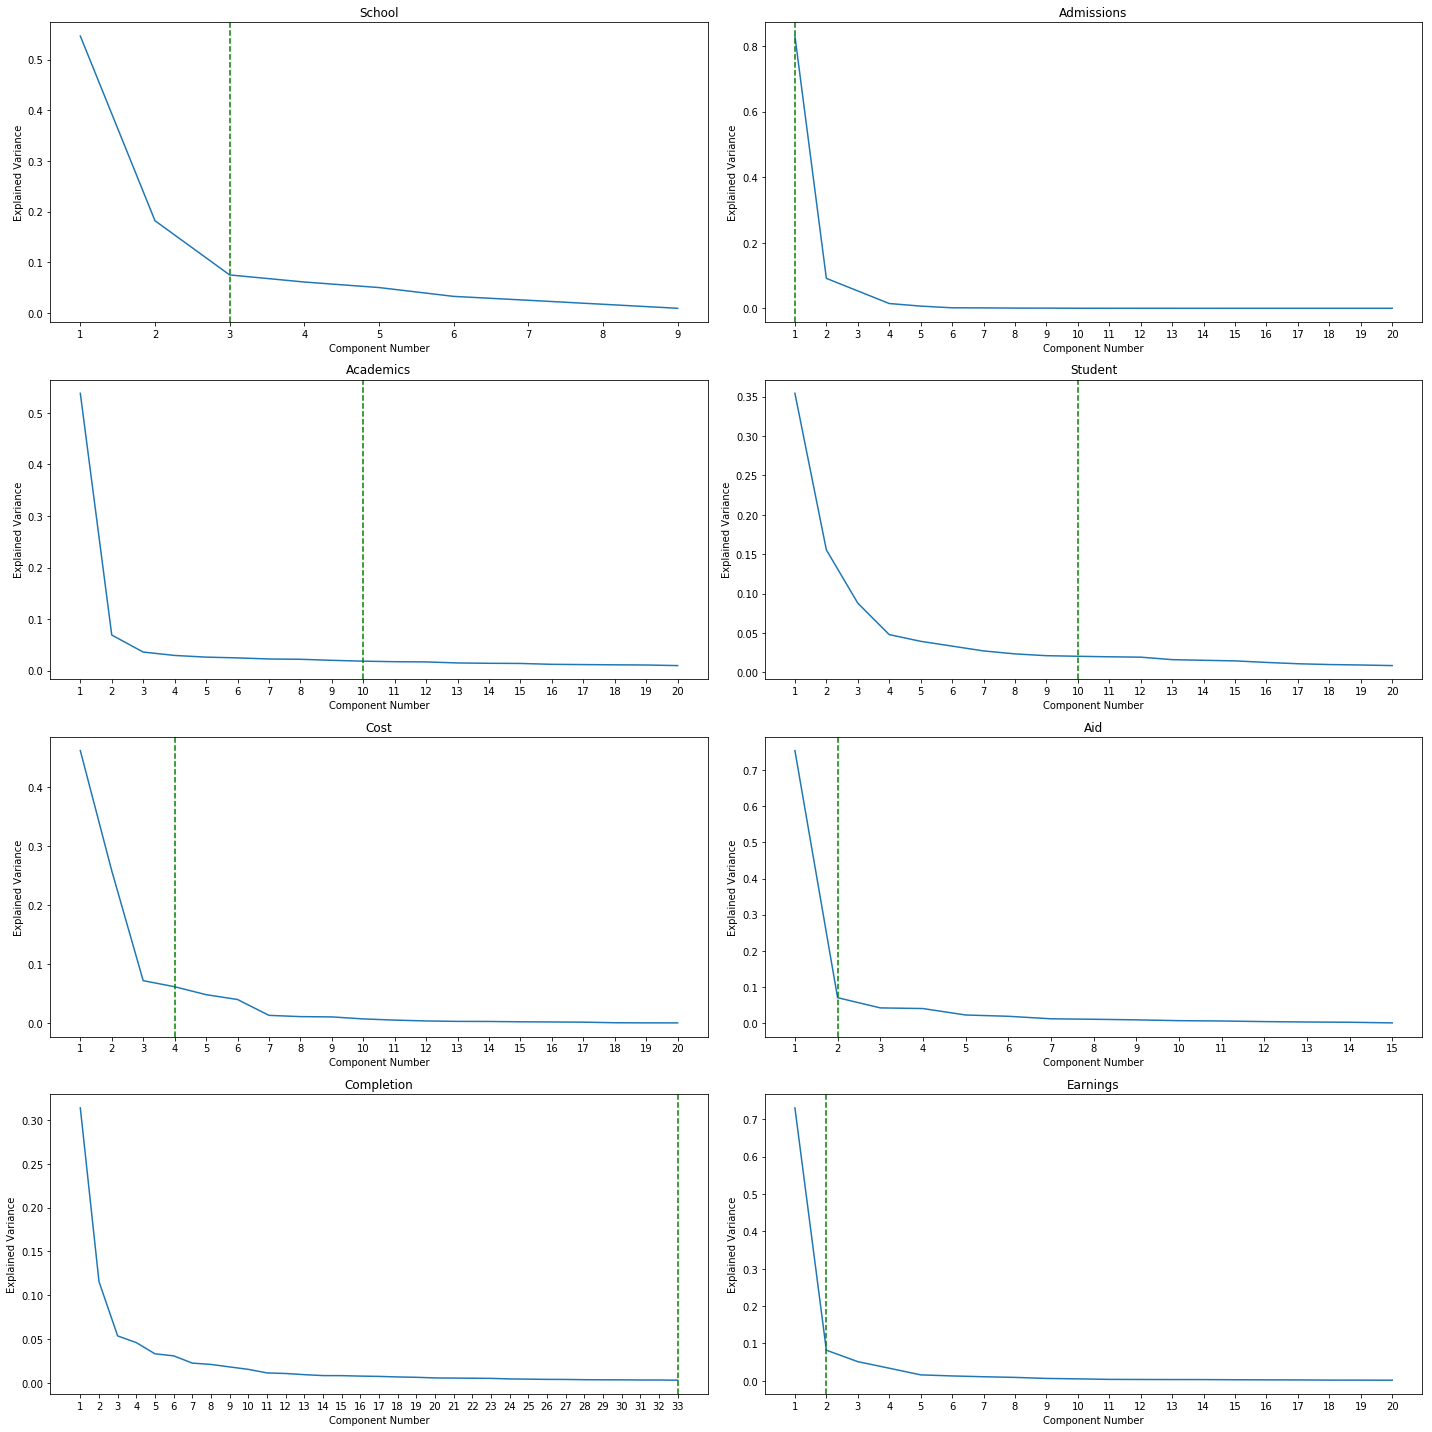

In [204]:
#pca = PCA(n_components=3)
fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(20,20))
ncom=[3,2,4,7,3,2,12,5]
i=0
for cat in cat_list:
    variables=dic.loc[dic.category==cat,'name']
    XX=X.loc[:,np.array(variables)].fillna(0)
    m=20
    if cat=='completion':
        m=PCA(0.8).fit(XX).n_components_
    pca=PCA(n_components=min(XX.shape[1],m))
    pca.fit(XX)
    print cat
    print XX.shape
    ax=axes[i/2,i%2]
    ax.plot(range(1,(pca.n_components_+1)),pca.explained_variance_ratio_,label="x")
    ax.set_xlabel('Component Number')
    ax.set_ylabel('Explained Variance')
    ax.set_xticks(range(1,(pca.n_components_+1)))
    ax.set_title(str(cat).title())
    ax.axvline(PCA(0.8).fit(XX).n_components_,linestyle='--',color='g')
    #ax.axvline(ncom[i],linestyle='--',color='g')
    i=i+1
plt.tight_layout()

### Linear Regression on PCA

In [229]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.cross_validation import cross_val_score
from sklearn.learning_curve import validation_curve
import statsmodels.formula.api as smf
import math

def rms_error(model, X, y):
    y_pred = model.predict(X)
    p_pred=np.exp(y_pred)/(1+np.exp(y_pred))
    p=np.exp(y)/(1+np.exp(y))
    return np.sqrt(np.mean((p - p_pred) ** 2))

def rms_error0(model, X, y):
    y_pred = model.predict(X)
    return np.sqrt(np.mean((y - y_pred) ** 2))

#pca = PCA(n_components=3)
vars=[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,0.95,0.99]
#vars=[0.8]
nfolds=10
val_train=np.zeros((len(vars),nfolds))
val_test=np.zeros((len(vars),nfolds))
for i, var in enumerate(vars):
    X_trans=None
    for cat in cat_list:
        variables=dic.loc[dic.category==cat,'name']
        XX=X.loc[:,np.array(variables)].fillna(0)
        pca=PCA(var)
        XX_trans=pca.fit_transform(XX)
        XX_trans=pd.DataFrame(XX_trans)
        X_trans=pd.concat([X_trans,XX_trans],axis=1)    
    y=rpyrt.RPY_1YR_RT
    model=LinearRegression()
    model.fit(X_trans,y) 
    print model.score(X_trans,y) # 0.842 for 80%
    cv=cross_val_score(LinearRegression(), X_trans, y ,cv=nfolds,scoring=rms_error)
    #print cv.mean() #0.0197086392425 for 80%
    val_train[i,:], val_test[i,:]=validation_curve(LinearRegression(), X_trans, y, 'fit_intercept',[True],cv=nfolds,scoring=rms_error)


0.715237064086
0.715237064086
0.715237064086
0.733242158174
0.746031758446
0.805354185546
0.8131617863
0.841931282134
0.855606718464
0.863340916683
0.872420762753


In [279]:
X_trans.shape
X.shape

(35027, 500)

In [221]:
lm=LinearRegression().fit(X, y)
lm.score(X, y)

0.87909863899779217

In [226]:
cv=cross_val_score(LinearRegression(), X, y ,cv=nfolds,scoring=rms_error)
print cv.mean()

0.01771947633


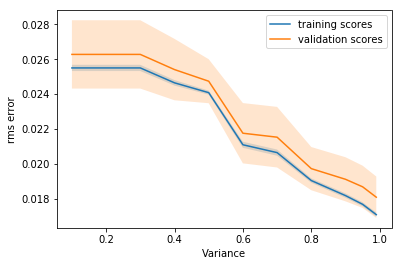

In [230]:
def plot_with_err(x, data, **kwargs):
    mu, std = data.mean(1), data.std(1)
    lines = plt.plot(x, mu, '-', **kwargs)
    plt.fill_between(x, mu - std, mu + std, edgecolor='none',
                     facecolor=lines[0].get_color(), alpha=0.2)

plot_with_err(vars, val_train, label='training scores')
plot_with_err(vars, val_test, label='validation scores')
plt.xlabel('Variance'); plt.ylabel('rms error')
plt.legend();

### Random Forest

In [274]:
from sklearn.ensemble import RandomForestRegressor

In [275]:
rf=RandomForestRegressor(20,oob_score = True).fit(X, y)

C:\Users\b_luo\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\ensemble\forest.py:720: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


In [276]:
cv=cross_val_score(rf, X, y ,cv=10,scoring=rms_error)
print cv.mean()

0.0152859906364


In [277]:
#sorted(rf.feature_importances_,reverse=True)
order_importance=sorted(range(len(rf.feature_importances_)), key=rf.feature_importances_.__getitem__,reverse=True)
feature_rf=X.columns[order_importance[0:26]]
#rf.feature_importances_[3]
#rf.feature_importances_.mean()

In [278]:
dic.loc[dic.name.isin(feature_rf),['desc','category','name']]

,desc,category,name
531,Total share of enrollment of undergraduate degree-seeking students who are black,student,UGDS_BLACK
539,Total share of enrollment of undergraduate degree-seeking students who are white non-Hispanic,student,UGDS_WHITENH
540,Total share of enrollment of undergraduate degree-seeking students who are black non-Hispanic,student,UGDS_BLACKNH
624,Percentage of undergraduates who receive a Pell Grant,aid,PCTPELL
675,Percent withdrawn from original institution within 2 years,completion,WDRAW_ORIG_YR2_RT
677,Percent who transferred to a 2-year institution and withdrew within 2 years,completion,WDRAW_2YR_TRANS_YR2_RT
690,"Percent of low-income (less than $30,000 in nominal family income) students who transferred to a...",completion,LO_INC_WDRAW_2YR_TRANS_YR2_RT
831,Percent of first-generation students withdrawn from original institution within 2 years,completion,FIRSTGEN_WDRAW_ORIG_YR2_RT
857,Percent withdrawn from original institution within 3 years,completion,WDRAW_ORIG_YR3_RT
859,Percent who transferred to a 2-year institution and withdrew within 3 years,completion,WDRAW_2YR_TRANS_YR3_RT


In [ ]:
dic.loc[dic.name.isin(feature_rf),:].groupby(['category']).count()

### Elatstic Net

In [207]:
help(ElasticNetCV)

Help on class ElasticNetCV in module sklearn.linear_model.coordinate_descent:

class ElasticNetCV(LinearModelCV, sklearn.base.RegressorMixin)
 |  Elastic Net model with iterative fitting along a regularization path
 |  
 |  The best model is selected by cross-validation.
 |  
 |  Read more in the :ref:`User Guide <elastic_net>`.
 |  
 |  Parameters
 |  ----------
 |  l1_ratio : float or array of floats, optional
 |      float between 0 and 1 passed to ElasticNet (scaling between
 |      l1 and l2 penalties). For ``l1_ratio = 0``
 |      the penalty is an L2 penalty. For ``l1_ratio = 1`` it is an L1 penalty.
 |      For ``0 < l1_ratio < 1``, the penalty is a combination of L1 and L2
 |      This parameter can be a list, in which case the different
 |      values are tested by cross-validation and the one giving the best
 |      prediction score is used. Note that a good choice of list of
 |      values for l1_ratio is often to put more values close to 1
 |      (i.e. Lasso) and less clo

(-0.23805478040021841,
 5.0040748819786076,
 -0.058308185953374433,
 0.12978610319537798)

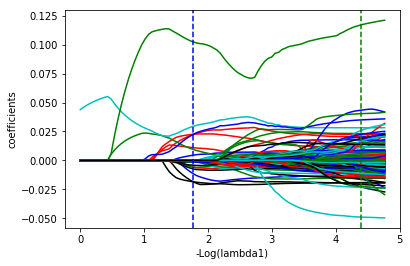

In [262]:
from sklearn.linear_model import lasso_path, enet_path
from itertools import cycle
alphas_enet, coefs_enet, _ = enet_path(
    X, y, 
    eps=5e-6,
    #eps=5e-3,
    l1_ratio=0.9,
    #alphas=[0.0001,0.02,0.03,0.05]
    #alphas=list(regr.alphas_[4,:]),
    fit_intercept=True
) # was -6
plt.figure(1)
ax = plt.gca()

colors = cycle(['b', 'r', 'g', 'c', 'k'])
neg_log_alphas_enet = -np.log10(alphas_enet)
index=neg_log_alphas_enet>0
for coef_e, c in zip(coefs_enet, colors):
    plt.plot(neg_log_alphas_enet[index], coef_e[index], c=c)

plt.xlabel('-Log(lambda1)')
plt.ylabel('coefficients')
plt.title('')
#plt.axvline(-np.log10(0.00320730087732),linestyle='--',color='g')
plt.axvline(-np.log10(4.06465829761e-05),linestyle='--',color='g') # for eps 5e-6
plt.axvline(-np.log10(0.0171476155889),linestyle='--',color='b') # for eps 5e-3
plt.axis('tight')


In [270]:
from sklearn.linear_model import ElasticNetCV
regr = ElasticNetCV(l1_ratio=0.9,cv=5, random_state=0
                    ,alphas=[0.0171476155889]
                    #,alphas=alphas_enet 
                   )
regr.fit(X, y)


ElasticNetCV(alphas=[0.0171476155889], copy_X=True, cv=5, eps=0.001,
       fit_intercept=True, l1_ratio=0.9, max_iter=1000, n_alphas=100,
       n_jobs=1, normalize=False, positive=False, precompute='auto',
       random_state=0, selection='cyclic', tol=0.0001, verbose=0)

In [271]:
print regr.alpha_
regr.l1_ratio_
regr.coef_[regr.coef_!=0].shape # 432 for eps 5e-6; 26 for eps 5e-3
#regr.mse_path_[59]

0.0171476155889


(26L,)

0.004147058823529412

In [263]:
model_en=ElasticNetCV(l1_ratio=[0.9],cv=5, random_state=0,
                      alphas=alphas_enet  # for eps 5e-5
                      #alphas=[4.06465829761e-05] # for eps 5e-3
                     )
cv=cross_val_score(model_en, X, y ,cv=nfolds,scoring=rms_error)
print cv.mean() # 0.0177268817896 for eps 5e-6; 0.0222588239378 for eps 5e-3

0.0177268817896


In [272]:
feature_en=sorted(range(len(regr. coef_ )), key=abs(regr. coef_ ).__getitem__,reverse=True)
size=len(regr.coef_[abs(regr. coef_ )>1e-6]) #26
print size

26


In [273]:
pd.options.display.max_colwidth = 100
f_en=X.columns[feature_en[0:size]]
dic.loc[dic.name.isin(f_en),:]


,desc,category,name
25,Control of institution,school,CONTROL
531,Total share of enrollment of undergraduate degree-seeking students who are black,student,UGDS_BLACK
539,Total share of enrollment of undergraduate degree-seeking students who are white non-Hispanic,student,UGDS_WHITENH
624,Percentage of undergraduates who receive a Pell Grant,aid,PCTPELL
675,Percent withdrawn from original institution within 2 years,completion,WDRAW_ORIG_YR2_RT
677,Percent who transferred to a 2-year institution and withdrew within 2 years,completion,WDRAW_2YR_TRANS_YR2_RT
818,Percent of students who never received a federal loan at the institution and withdrew from origi...,completion,NOLOAN_WDRAW_ORIG_YR2_RT
845,Percent of not-first-generation students who transferred to a 4-year institution and withdrew wi...,completion,NOT1STGEN_WDRAW_4YR_TRANS_YR2_RT
846,Percent of not-first-generation students who transferred to a 2-year institution and withdrew wi...,completion,NOT1STGEN_WDRAW_2YR_TRANS_YR2_RT
859,Percent who transferred to a 2-year institution and withdrew within 3 years,completion,WDRAW_2YR_TRANS_YR3_RT


In [ ]:
 list(set(X.columns[feature_en[0:27]]).intersection(X.columns[order_importance[0:27]]))

In [ ]:
dic.loc[dic.name.isin(feature_en),:].groupby(['category']).count()